In [1]:
import numpy as np
import cv2
from cv2 import aruco
from pathlib import Path
from PIL import Image
print(cv2.__version__)

4.8.0


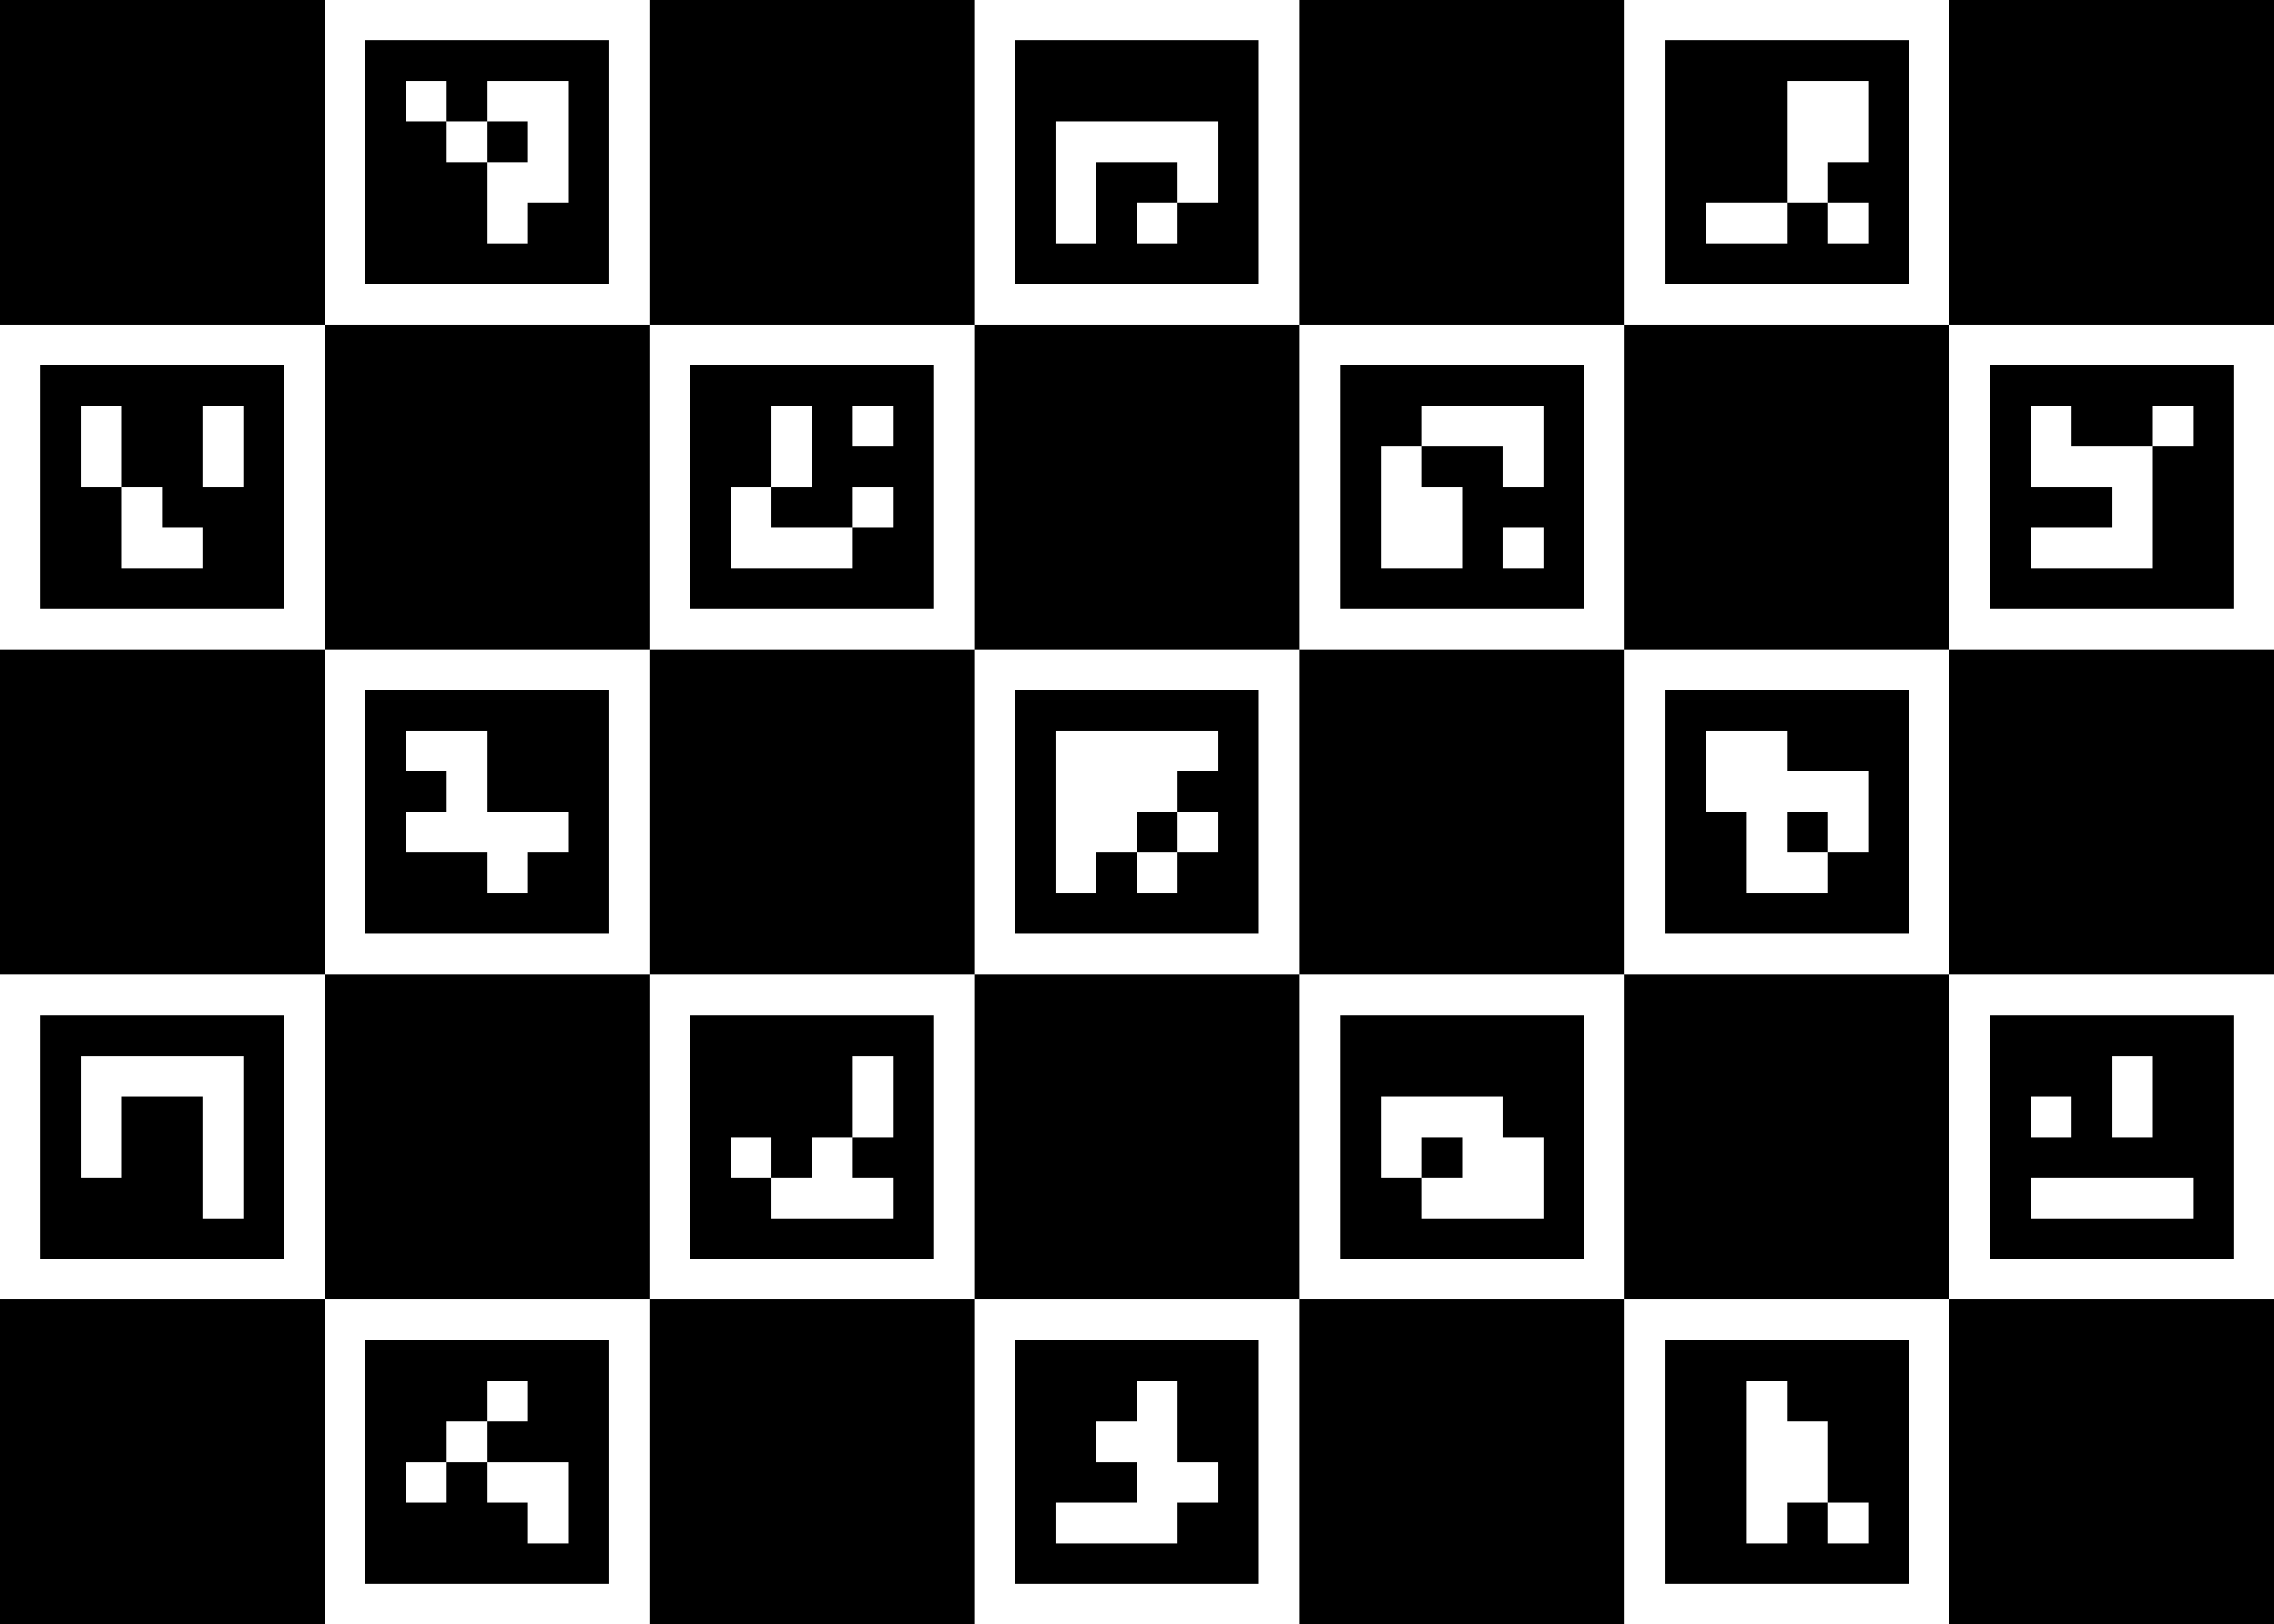

In [2]:
# create ChArUco
#@title Change to the actual measurement of the printout
squareLength = 0.04 # @param {type:"number"}
markerLength = 0.03 # @param {type:"number"}
path = "." # @param {type:"string"}
path = Path(path)
dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
board = aruco.CharucoBoard((7, 5), squareLength, markerLength, dictionary)
imboard = board.generateImage((3500, 2500))
cv2.imwrite(str(path / 'charuco_board.png'), imboard)
display(Image.fromarray(imboard))

In [3]:
# inputs
cameraMatrix = np.loadtxt(path / 'intrinsic.txt')
distCoeffs = np.zeros(4)
image = cv2.imread(str(path / 'image.png'))

one marker corner:
[[[510.12247 597.9944 ]
  [579.9606  593.31134]
  [579.9966  672.6207 ]
  [511.31888 676.1989 ]]]
marker_corners subpixel-accurate: True


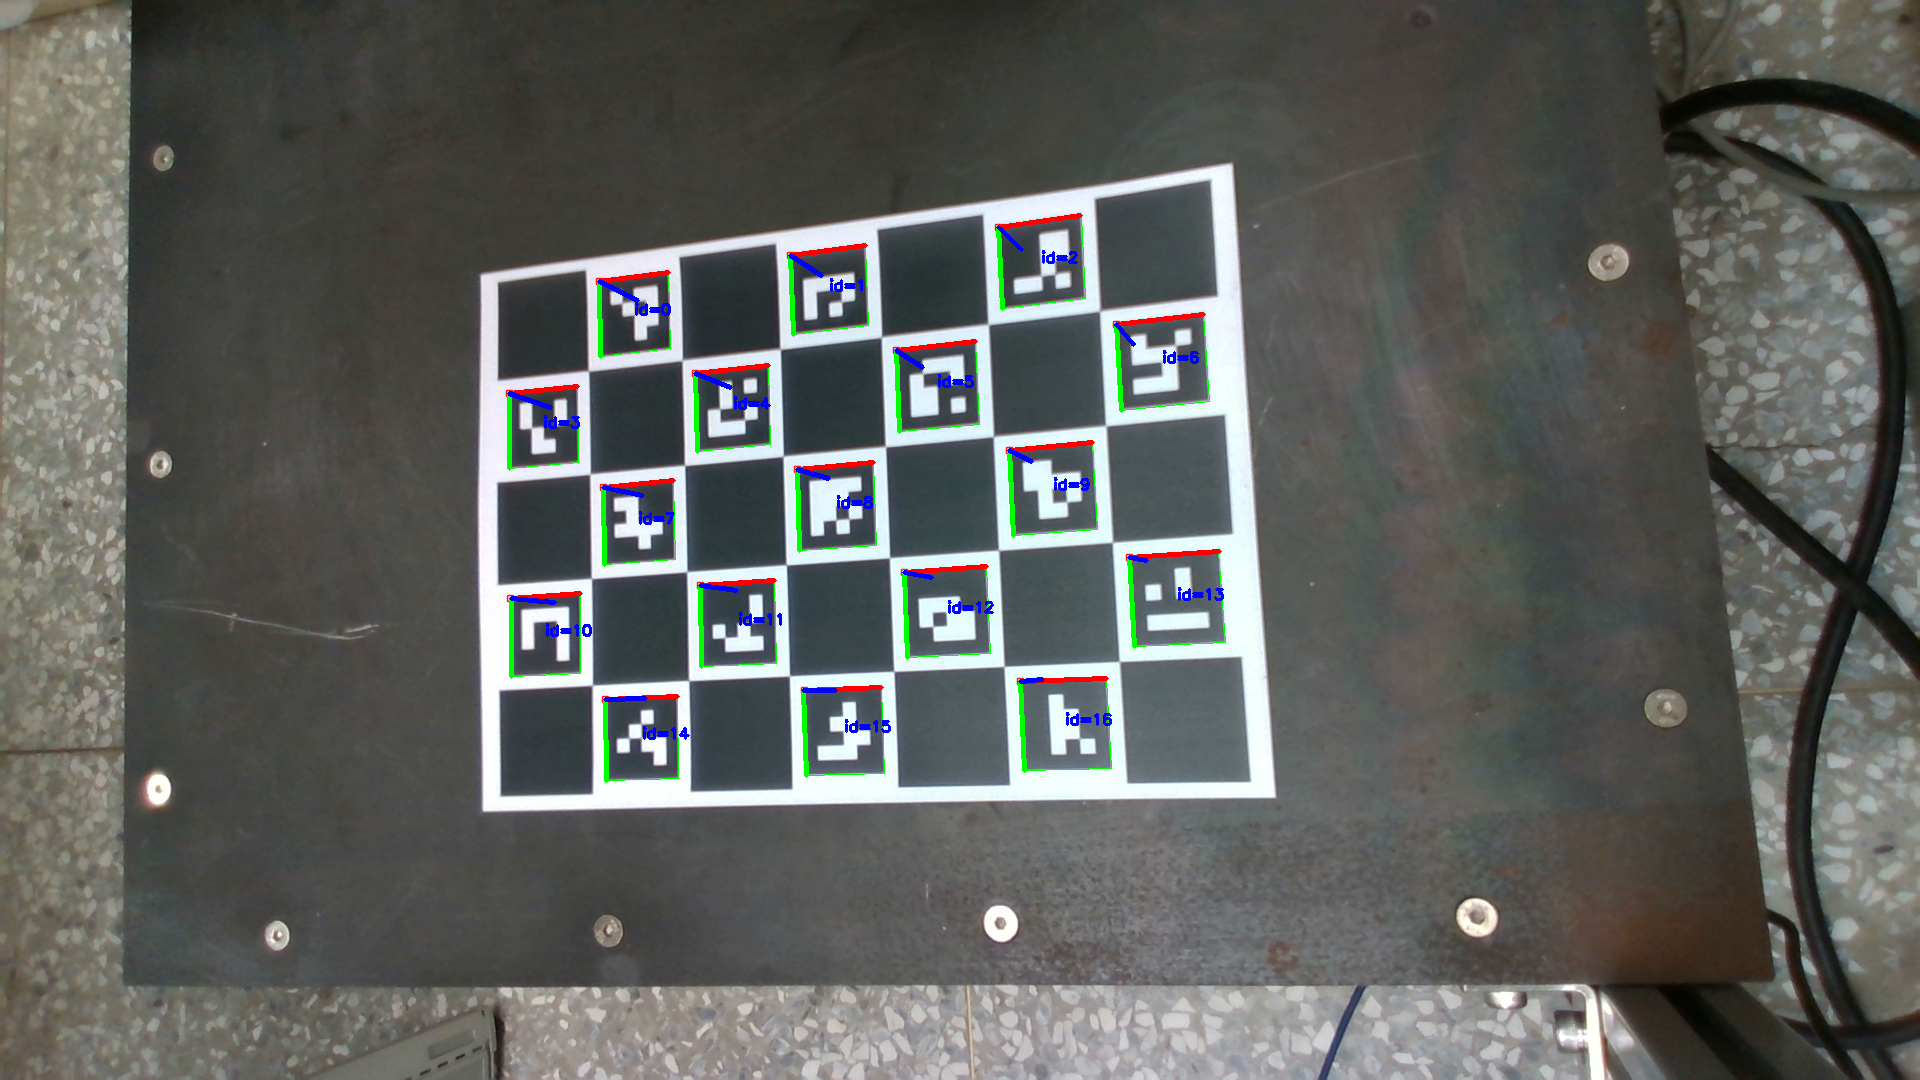

In [4]:
# detect markers

detector_params = aruco.DetectorParameters()
detector_params.cornerRefinementMethod = aruco.CORNER_REFINE_APRILTAG
# detector_params.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
# CORNER_REFINE_SUBPIX has bug: https://github.com/opencv/opencv/issues/24113
detector = aruco.ArucoDetector(dictionary, detector_params)
marker_corners, marker_ids, rejected_candidates = detector.detectMarkers(image)
print(f'one marker corner:\n{marker_corners[0]}')

def check_subpixel(corners):
    for xy in np.asarray(corners).flatten():
        if not xy.is_integer():
            return True
    return False

print(f"marker_corners subpixel-accurate: {check_subpixel(marker_corners)}")

immarkers = aruco.drawDetectedMarkers(image.copy(), marker_corners, marker_ids)

# copy from https://github.com/opencv/opencv-python/issues/755#issuecomment-1387116284
objPoints = np.array([[0., 0., 0.], [1., 0., 0.], [1., 1., 0.], [0., 1., 0.]])
for marker_corner in marker_corners:
    valid, rvec, tvec = cv2.solvePnP(objPoints, marker_corner, cameraMatrix, distCoeffs)
    cv2.drawFrameAxes(immarkers, cameraMatrix, distCoeffs, rvec, tvec, 1)

display(Image.fromarray(cv2.cvtColor(immarkers, cv2.COLOR_BGR2RGB)))

one marker corner:
[[[510.12247 597.9944 ]
  [579.9606  593.31134]
  [579.9966  672.6207 ]
  [511.31888 676.1989 ]]]
marker_corners subpixel-accurate: True
one charuco corner:
[[588.84454 371.31458]]
charuco_corners subpixel-accurate: True


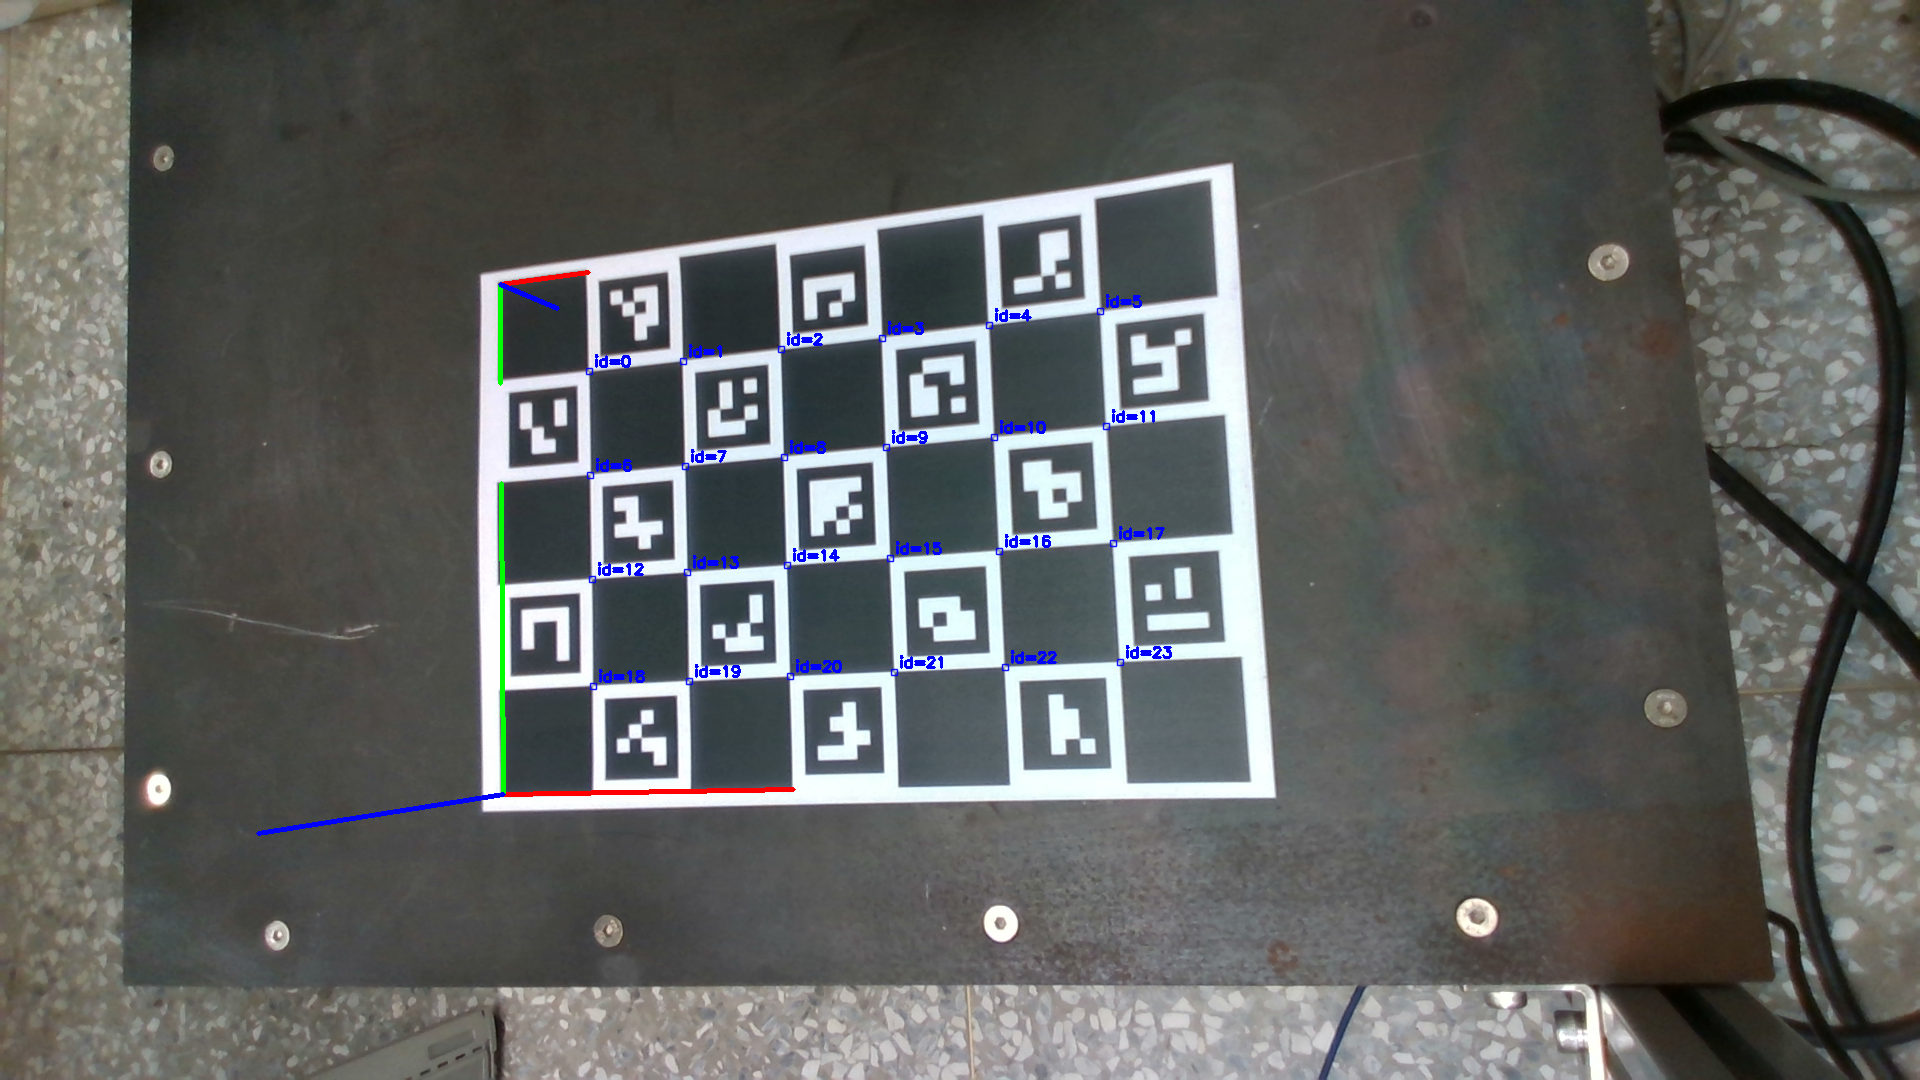

In [5]:
# detect charuco

# example
# https://github.com/AleksandrPanov/opencv/blob/3421b950ce105358c9be0af14a7b8c514449e2ff/samples/python/aruco_detect_board_charuco.py

detector_params = aruco.CharucoParameters()
detector_params.cameraMatrix = cameraMatrix # not sure if this will be more accurate, https://github.com/opencv/opencv/blob/6ae7caaa0107b8e1507b8de40c754c908f24a243/modules/objdetect/src/aruco/charuco_detector.cpp#L314C37-L314C37

charuco_detector = aruco.CharucoDetector(board, detector_params)
# pass subpixel-accurate marker_corners to charuco_detector, not sure if this will be more accurate
charuco_corners = charuco_ids = None
charuco_corners, charuco_ids, charuco_marker_corners, charuco_marker_ids = charuco_detector.detectBoard(image, charuco_corners, charuco_ids, marker_corners, marker_ids)
# charuco_marker_corners will be same as marker_corners

# can also detectBoard without passing marker_corners, https://github.com/opencv/opencv/blob/6ae7caaa0107b8e1507b8de40c754c908f24a243/modules/objdetect/src/aruco/charuco_detector.cpp#L308C92-L308C92
# charuco_corners, charuco_ids, charuco_marker_corners, charuco_marker_ids = charuco_detector.detectBoard(image)
for i, corner in enumerate(marker_corners):
    if (corner != charuco_marker_corners[i]).any():
        print('not same')

print(f'one marker corner:\n{marker_corners[0]}')
print(f"marker_corners subpixel-accurate: {check_subpixel(marker_corners)}")

print(f'one charuco corner:\n{charuco_corners[0]}')
print(f"charuco_corners subpixel-accurate: {check_subpixel(charuco_corners)}")

imcharuco = aruco.drawDetectedCornersCharuco(np.copy(image), charuco_corners, charuco_ids)

# charuco axis
objPoints, imgPoints = board.matchImagePoints(charuco_corners, charuco_ids)
valid, rvec, tvec = cv2.solvePnP(objPoints, imgPoints, cameraMatrix, distCoeffs)
cv2.drawFrameAxes(imcharuco, cameraMatrix, distCoeffs, rvec, tvec, squareLength)


# old charuco axis
# copy from https://github.com/opencv/opencv-python/issues/755#issuecomment-1384544416
def matchImagePoints(charuco_board, charuco_corners, charuco_ids):
    objPoints = []
    imgPoints = []
    for i in range(0, len(charuco_ids)):
        index = charuco_ids[i]
        objPoints.append(charuco_board.getChessboardCorners()[index])
        objPoints[-1][0][1] = charuco_board.getRightBottomCorner()[1] - objPoints[-1][0][1]  # set old axis direction
        imgPoints.append(charuco_corners[i])
    return np.array(objPoints), np.array(imgPoints)

objPoints, imgPoints = matchImagePoints(board, charuco_corners, charuco_ids)
valid, rvec, tvec = cv2.solvePnP(objPoints, imgPoints, cameraMatrix, distCoeffs)
cv2.drawFrameAxes(imcharuco, cameraMatrix, distCoeffs, rvec, tvec, squareLength * 3)

display(Image.fromarray(cv2.cvtColor(imcharuco, cv2.COLOR_BGR2RGB)))

In [6]:
# save output images
cv2.imwrite(str(path / 'markers.png'), immarkers)
cv2.imwrite(str(path / 'charuco.png'), imcharuco)

True

In [7]:
# output transformation matrix
rotation_matrix = cv2.Rodrigues(rvec)[0]
charuco_tf = np.concatenate((np.concatenate((rotation_matrix, tvec), axis=1), np.array([[0, 0, 0, 1]])))
print('charuco transformation matrix')
print(charuco_tf)
np.savetxt(path / 'charuco_tf.txt', charuco_tf)

camera_position = -np.matrix(rotation_matrix).T * np.matrix(tvec)
camera_tf = np.concatenate((np.concatenate((rotation_matrix.T, camera_position), axis=1), np.array([[0, 0, 0, 1]])))
print('camera transformation matrix = inverse of charuco transformation matrix')
print(camera_tf)
np.savetxt(path / 'camera_tf.txt', camera_tf)

charuco transformation matrix
[[ 0.95478686 -0.04230553 -0.29426568 -0.17014777]
 [-0.07313604 -0.99282859 -0.09456486  0.10494467]
 [-0.28815476  0.11181071 -0.95103375  0.51992593]
 [ 0.          0.          0.          1.        ]]
camera transformation matrix = inverse of charuco transformation matrix
[[ 0.95478686 -0.07313604 -0.28815476  0.31994922]
 [-0.04230553 -0.99282859  0.11181071  0.03886059]
 [-0.29426568 -0.09456486 -0.95103375  0.45432254]
 [ 0.          0.          0.          1.        ]]
